In [1]:
import sys
sys.path.append('../src/')
from vi_hrg_fix import *
from utils import c2d, hyperdist, p_hd, polar2cart, warn_tensor, unit_circle, arcosh
from torch import autograd
torch.manual_seed(42)

In [2]:
logit = lambda x: (x/(1-x)).log()

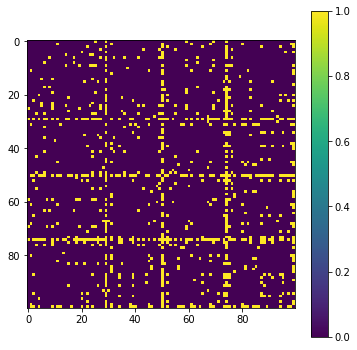

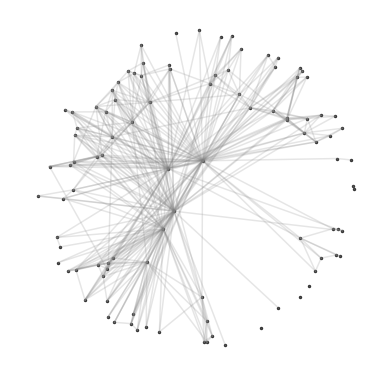

In [3]:
N = 100
R = torch.tensor([8.0]).double()
alpha = .7
T = 0.2

G = HRG(R=R, alpha=alpha, T=T)
r, theta, A = G.generate(N)
G.show()
G.plot()

In [4]:
r_loc_init = logit(r/R)
phi_loc_init = polar2cart(1, theta)

In [5]:
def lh(r_loc_init, phi_loc_init, R,T,alpha):
    r_scale_init = (torch.ones([N]).double()/100).log()    
    phi_scale_init = (torch.ones([N]).double()*100000).log()
    dataloader = DataLoader(EdgesDataset(A), batch_size=int(N), shuffle=True, num_workers=0)
    vi = VI_HRG(N,20, init_values={
                                              'rs_loc':r_loc_init,
                                              'rs_scale':r_scale_init,
                                              'phis_loc':phi_loc_init,
                                              'phis_scale':phi_scale_init, 
                                              'R_conc':None, 
                                              'R_scale':None,
                                              'alpha_conc':None,
                                              'alpha_scale':None,
                                              'T':None},
                           fixed={'R':R, 
                                  'T':T,
                                  'alpha':alpha})
    vi.dataloader = dataloader
    return vi.likelihood()

### True values likelihood

In [6]:
lh(r_loc_init, phi_loc_init, R, T , alpha)

../src/vi_hrg_fix.py:288: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R_samples = torch.tensor(self.Rf).clone().detach().to(self.device).to(self.dtype).expand([self.num_samples])


-1810.3237569027924

In [7]:
Rs = torch.arange(0.5, 10., 0.5)
Ts = torch.arange(0.05, 1., 0.05)
alphas = torch.arange(.05, 1., .05)
lh_a = []
for a in alphas:
    lh_ =[]
    for R in Rs:
        lh__ = []
        for T in Ts:
            lh__.append(lh(r_loc_init, phi_loc_init, R, T , a))
        lh_.append(lh__)
    lh_a.append(lh_)

../src/vi_hrg_fix.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T_samples = torch.tensor(self.Tf).clone().detach().to(self.device).to(self.dtype).expand([self.num_samples])
../src/vi_hrg_fix.py:296: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha_samples = torch.tensor(self.alphaf).clone().detach().to(self.device).to(self.dtype).expand([self.num_samples])
../src/utils.py:120: UserWarning: p_raw has NaN in it!
  warnings.warn(str('%s has NaN in it!' % variable))
../src/utils.py:120: UserWarning: log_pA has NaN in it!
  warnings.warn(str('%s has NaN in it!' % variable))
../src/utils.py:126: UserWarning: p_raw has 1 in it!
  warnings.warn(str('%s has 1 in it!' % variable))


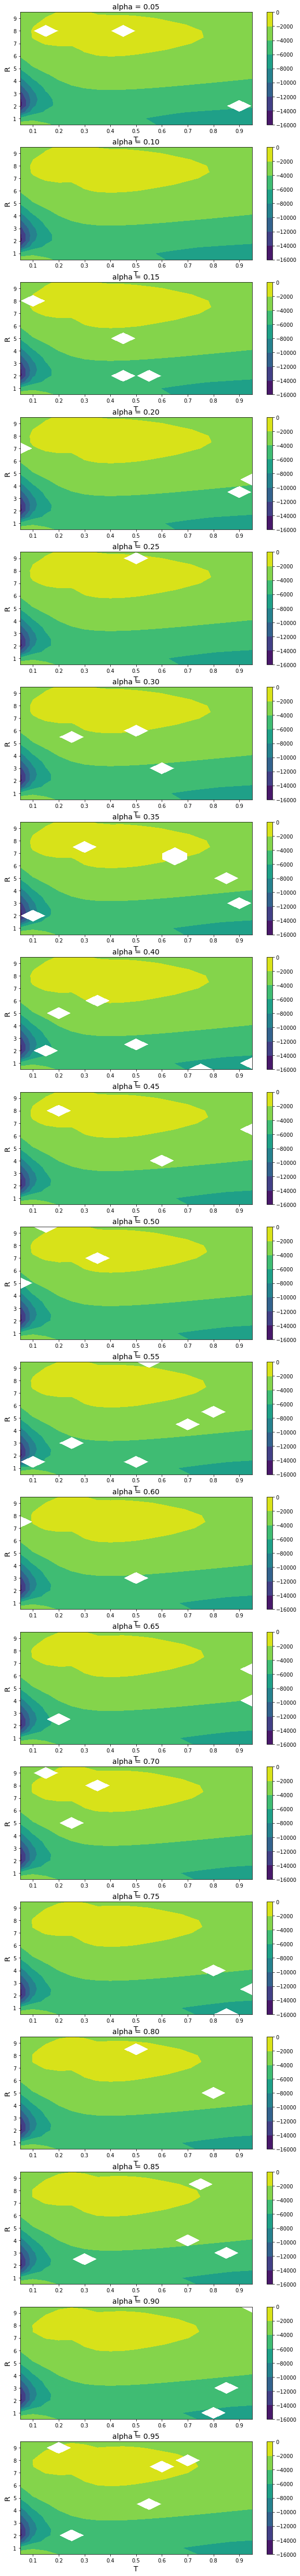

In [8]:
fig, axs = plt.subplots(len(alphas),1, figsize=(10, 90))
#fig.subplots_adjust(hspace = .5, wspace=.05)
#axs = axs.ravel()
#fig.suptitle(title, size=24)
    
for i in range(len(alphas)):
    im = axs[i].contourf(Ts.numpy(), Rs.numpy(), lh_a[i])
    axs[i].set_title(str('alpha = %.2f' %  alphas[i].item()), fontsize=14)
    axs[i].set_xlabel('T', fontsize=14)
    axs[i].set_ylabel('R', fontsize=14)
    fig.colorbar(im, ax=axs[i])

plt.show()

In [9]:
l = torch.tensor(lh_a)
l = torch.where(torch.isnan(l), torch.ones(l.size())*(-2500), l)
l.max()

tensor(-1641.7994)

In [10]:
max_index = np.unravel_index(l.argmax(), l.shape)

In [11]:
a_max = alphas[max_index[0]]
R_max = Rs[max_index[1]]
T_max = Ts[max_index[2]],
a_max, R_max, T_max

(tensor(0.2000), tensor(7.5000), (tensor(0.4500),))

In [12]:
lh(r_loc_init, phi_loc_init, R_max, T_max , a_max)

-1641.9563793098166